In [60]:
import numpy as np
import random
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel
## ENSEMBLE

from sklearn.ensemble import BaggingRegressor

# add project root folder to path to allow import local modules
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
# import local modules
from stochastic_models import *
from visualisations import *
from basic_estimator_model import *

## Parameter Configuration

In [61]:
np.random.seed(2020)

In [62]:
N_train = 5000
N_test = 10000
d = 1
T = 2

In [63]:
lambda_range = (N_train*1e-9 , N_train*1e-3)
alpha_range = (8.3*1e-5, 0.83)
length_scale = np.sort(1/np.sqrt((2*alpha_range[0], 2*alpha_range[1])))

## Create Kernel & prepare datasets

In [64]:
#kernel
kernel = RBF(length_scale= (length_scale[0] + length_scale[1])/2, length_scale_bounds=length_scale) \
        + WhiteKernel(noise_level= (lambda_range[0] + lambda_range[1])/2 , noise_level_bounds=lambda_range)


In [65]:
#generate drivers
s_train = MaxCallStochasticModel(N_train,d,[1/12,11/12])
s_train.generate_samples()
s_test = MaxCallStochasticModel(N_test, d, [1/12,11/12])
s_test.generate_samples()

In [66]:
#prepare datasets & values
y_train = s_train.y
X_train = s_train.X
S_train = s_train.S

y_test = s_test.y
X_test = s_test.X
S_test = s_test.S

V_T = y_test  
V_0 = s_test.generate_true_V(0)

V_0= V_0.mean()
V_0 # Average expected PROFIT!

0.07892604992843537

In [67]:
# 
def Flatten_Training_Sample(X , f):
    return np.array([f(x) for x in X])
#Shape of each sample j: [X_j[0,0],... ,X_j[d,0],...,X_j[0,T] , ..., X_j[d,T]]
Flatten_X_1_train = Flatten_Training_Sample(X_train, lambda x : x.T.flatten())
Flatten_X_1_test = Flatten_Training_Sample(X_test, lambda x : x.T.flatten())


## Create Custom Models
(to have more control of splitting etc)

In [68]:
from sklearn.base import clone, BaseEstimator
class BaggingBaseClass(BaseEstimator):
    def __init__(self,M,predictor):
        super().__init__()
        self.M = M
        self.predictor = predictor
        self.predictors = None
        
    def _split_train_set(self,X,y):
        raise NotImplementedError
    
    def fit(self,X,y):
        print("fit")
        print(X.shape)
        self.predictors  = [clone(self.predictor)] *self.M
        X_list,y_list = self._split_train_set(X,y)
        for i in range(self.M):
            self.predictors[i].fit(X_list[i],y_list[i])
    
    def predict(self,X):
        print("predict")
        print(X.shape)
        predictions = np.zeros((X.shape[0]))
        for i in range(self.M):
            predictions = predictions + self.predictors[i].predict(X)
        predictions = predictions / self.M 
        return predictions

class SimplePaster(BaggingBaseClass):
    def __init__(self,M,predictor):
        super(SimplePaster,self).__init__(M,predictor)
    
    def _split_train_set(self,X,y):
        n = X.shape[0]// self.M
        X_list = []
        y_list = []
        for i in range(self.M-1):
            X_list.append(X[n*i:n*(i+1)])
            y_list.append(y[n*i:n*(i+1)])
        X_list.append(X[(self.M-1)*n:])
        y_list.append(y[(self.M-1)*n:])
        return X_list, y_list
    
s = SimplePaster(11,None)
s.get_params()

{'M': 11, 'predictor': None}

## SKLearn GridSearch

In [45]:
#https://scikit-learn.org/stable/modules/generated/sklearn.metrics.make_scorer.html
# this one could be used in GridSearches 
def create_scorer(V_0):
    def normalized_error_VT(y_hat,y):
            #y_hat= f_X predicted
            # y = V_T = f_X
            Normalized_Error_T = np.sqrt(1/len(y)*np.sum((y_hat-y)**2, axis=0))/V_0
            ## see formula p4 for ||f(X)||2,Q 
            ## since samples are drawn according to measure - just sum them up
            return Normalized_Error_T
    return normalized_error_VT


In [46]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
M_grid = np.arange(1,10)
base_regressor = GaussianProcessRegressor(kernel)
tuned = {"M": M_grid }
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
gs = GridSearchCV(SimplePaster(1,base_regressor), tuned,scoring = make_scorer(create_scorer(V_0)),cv=5,n_jobs=-1)
gs.fit(Flatten_X_1_train,y_train)

fit
(1000, 2)


GridSearchCV(cv=5,
             estimator=SimplePaster(M=1,
                                    predictor=GaussianProcessRegressor(kernel=RBF(length_scale=39.2) + WhiteKernel(noise_level=0.5))),
             n_jobs=-1, param_grid={'M': array([1])},
             scoring=make_scorer(normalized_error_VT))

In [47]:
gs.cv_results_

{'mean_fit_time': array([1.9759336]),
 'std_fit_time': array([0.7541994]),
 'mean_score_time': array([0.00859904]),
 'std_score_time': array([0.00318336]),
 'param_M': masked_array(data=[1],
              mask=[False],
        fill_value='?',
             dtype=object),
 'params': [{'M': 1}],
 'split0_test_score': array([0.14922542]),
 'split1_test_score': array([0.22897747]),
 'split2_test_score': array([0.11906916]),
 'split3_test_score': array([0.37396664]),
 'split4_test_score': array([0.36555053]),
 'mean_test_score': array([0.24735784]),
 'std_test_score': array([0.10623097]),
 'rank_test_score': array([1])}

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_M,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,1.975934,0.754199,0.008599,0.003183,1,{'M': 1},0.149225,0.228977,0.119069,0.373967,0.365551,0.247358,0.106231,1


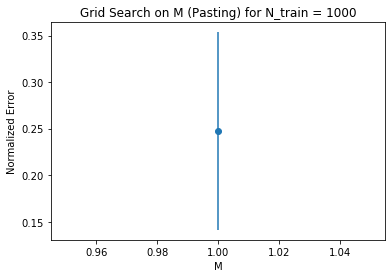

In [48]:
mean = gs.cv_results_['mean_test_score']
std = gs.cv_results_['std_test_score']
plt.title(f"Grid Search on M (Pasting) for N_train = {N_train}")
plt.xlabel("M")
plt.ylabel("Normalized Error")
plt.errorbar(M_grid,mean,std,marker='o')
plt.savefig(f"../img/pasting_gridsearch_{N_train}")
import pandas as pd 
df = pd.DataFrame.from_dict(gs.cv_results_)
df

## Compare with own grid search to validate Scikit GSCV

NB: for convenience - just on split -> match with column

In [49]:
normalized_errors = []
base_regressor = GaussianProcessRegressor(kernel=kernel)
for M in M_grid:
    paster = SimplePaster(M,base_regressor)
    paster.fit(Flatten_X_1_train[N_train//5:],y_train[N_train//5:])
    y_hat = paster.predict(Flatten_X_1_train[:N_train//5])
    normalized_errors.append([M,create_scorer(V_0)(y_hat,y_train[:N_train//5])])

fit
(800, 2)
predict
(200, 2)


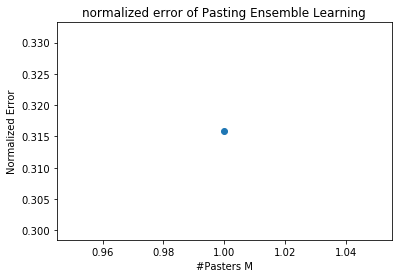

In [53]:
#print(normalized_errors)
normalized_errors = np.array(normalized_errors)
plt.plot(normalized_errors[:,0],normalized_errors[:,1],"-o")
plt.title("normalized error of Pasting Ensemble Learning")
plt.ylabel("Normalized Error")
plt.xlabel("#Pasters M")
plt.show()

In [69]:
normalized_errors = []
base_regressor = GaussianProcessRegressor(kernel=kernel)
for M in M_grid:
    paster = SimplePaster(M,base_regressor)
    paster.fit(Flatten_X_1_train,y_train)
    y_hat = paster.predict(Flatten_X_1_test)
    normalized_errors.append([M,create_scorer(V_0)(y_hat,y_test)])

fit
(2000, 2)
predict
(10000, 2)


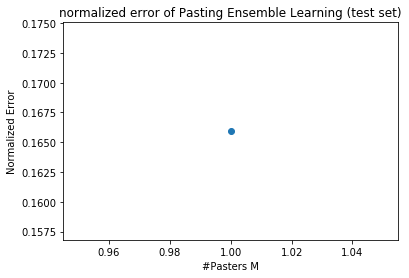

In [70]:
#print(normalized_errors)
normalized_errors = np.array(normalized_errors)
plt.plot(normalized_errors[:,0],normalized_errors[:,1],"-o")
plt.title("normalized error of Pasting Ensemble Learning (test set)")
plt.ylabel("Normalized Error")
plt.xlabel("#Pasters M")
plt.show()